<a href="https://colab.research.google.com/github/maximilianparker/Tracking_python/blob/main/Sine_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

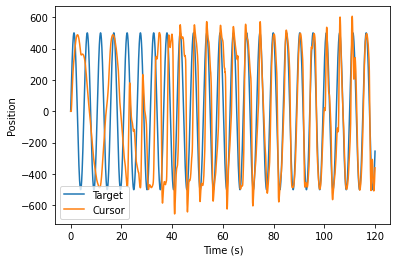

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 26 18:04:32 2021

@author: Max Parker
"""
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plot

# parameters of the tracking program
Fs = 60                                     # sample frequency
Ts = 1/Fs                                   # sample time
duration = 120.0                            # trial duration
time = np.arange(0, duration/Ts, 1);        # time

# parameters for the reorganisation model
reorg_gain = .0000001                       # gain of reorganisation system (learning rate parameter)
ROC=random.rand(3)-.5                       # initial rate of change parameters for trial and error learning
reorg_err_threshold=10                      # reorganise only when error exceeds threshold

# Amplitude of the target
target = 500*np.sin(.02*time)               # target position
target_vel = np.diff(target,1)              # target velocity
# plot.plot(time*Ts,target)

# Model parameters
theta = [500.00,.01,0.00]                   # sine input function init conditions
tau = 15                                    # input delay
K = 30                                      # output gain
S = .1                                      # leak rate
R = 0                                       # Reference value

cursor = np.zeros(int(duration/Ts))        # cursor init position
cursor_vel = np.zeros(int(duration/Ts))    # cursor init velocity

memory_trace=np.zeros(2)                   # initialise memory
e=np.zeros(int(duration/Ts))               # initialise error
abs_e=np.zeros(int(duration/Ts))           # initialise absolute error
s=[int(duration/Ts),3]                                        
parameters=np.zeros(s)                     # initialise parameter list


# model
for i in range(tau,int(duration/Ts)):
    
    
    ########### Track ############
    if i == tau:
        memory_trace=target[i-tau]
    else:
        memory_trace=np.append(memory_trace,target[i-tau])          # laying memory of previously seen trace as it comes in
    
    pattern = theta[0]*np.sin(theta[1]*memory_trace )               # fit sine to memory trace  
    
    x=np.arange(1,duration/Ts+1)
    pattern_est = theta[0]*np.sin(theta[1]*x );                     # extrapolate sine across length of trial  
    pred = pattern_est[i]                                           # predicted position of target location on basis of model
    

    error = R-(cursor[i-tau] - pred)                                # error signal
    cursor[i] = cursor[i-1] + (S*(K*(error) - cursor[i-1]))*Ts;     # output
    cursor_vel[i] = cursor[i]-cursor[i-1];                          # output velocity
    
    e[i] = cursor[i] - target[i]                                    # tracking error
    abs_e[i]= abs(e[i])                                             # absolute tracking error
    
    
    ########### Reorganise #########
    parameters[i,] = theta                                          # parameters on current trial
    
    if abs_e[i] > reorg_err_threshold:                              # reorganise if abs error is above reorg threshold
        
        e_dt = abs_e[i]-abs_e[i-1];                                 # rate of change in tracking error
    
        if (e_dt > 0):                                              # if error increased
            ROC = random.rand(3)-.5                                 # set new rate of change
    
        theta = theta + reorg_gain * (abs_e[i] * ROC);              # reorganise
    
        if theta[0] < 0:
            theta[0] = parameters[i,0];                             # stop parameter going below zero

        if theta[1] < 0:
            theta[1] = parameters[i,1];                             # stop parameter going below zero
    else:
        theta =  parameters[i,]

plot.plot(time*Ts,target,time*Ts,cursor)
plot.xlabel('Time (s)')
plot.ylabel('Position')
plot.legend(['Target','Cursor'])
